# Image classification in regard their orientation using MobileNet and ResNet50 models to validate source dataset
* prepare datasets
* build and train models
* estimate orientaions
* evaluate results

In [1]:

%load_ext autoreload
%autoreload 2


#---configuring paths---
import sys, os
#!{sys.executable} -m pip install isort autoflake
from pathlib import Path
from pprint import pprint

#---setting up the PYTHONPATH------

# Current directory as Path object
current_dir = Path.cwd()
# get project root folder
project_dir = str(current_dir.parent)
# adding project directory to the PYTHONPATH
if project_dir not in sys.path:
    sys.path.append(project_dir)
    print(f"PYTHONPATH added: {project_dir}")
else:
    print("PYTHONPATH was empty or already in sys.path.")

sys.path.append(project_dir)
pprint(sys.path)


#----setting data paths----
from src import defs

defs.initDataPaths(project_dir)
defs.checkDataPaths()

# --- Standard library
import json
import os

# --- Third-party libraries
import cv2
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- Local application imports
from src.defs import (
    DatasetType as dt,
    ModelType as mt,
    MLRUNS_URI,
    PROJECT_DIR,
    class_to_orientation_map
)
from src.models.modelbuilder import ModelBuilder
from src.models.modeltrainer import ModelTrainer
from src.models.modelutilizer import ModelUtilizer
from src.utils.datahelper import DataHelper as dh
from src.utils.imgprocessing import ImageProcessor as ip


PYTHONPATH added: c:\Users\User\DataScience\aug24_cds_int_analysis-of-covid-19-chest-x-rays
['C:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip',
 'C:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python312\\DLLs',
 'C:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python312\\Lib',
 'C:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python312',
 'c:\\Users\\User\\DataScience\\env_covid19',
 '',
 'c:\\Users\\User\\DataScience\\env_covid19\\Lib\\site-packages',
 'c:\\Users\\User\\DataScience\\env_covid19\\Lib\\site-packages\\win32',
 'c:\\Users\\User\\DataScience\\env_covid19\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\User\\DataScience\\env_covid19\\Lib\\site-packages\\Pythonwin',
 'c:\\Users\\User\\DataScience\\aug24_cds_int_analysis-of-covid-19-chest-x-rays',
 'c:\\Users\\User\\DataScience\\aug24_cds_int_analysis-of-covid-19-chest-x-rays']
file:///c:/Users/User/DataScience/aug24_cds_int_analysis-of-covid-19-chest-x-rays/mlruns

PROJECT_DIR:  c:\Users\

In [ ]:
#-----preparing training/validation and test datasets with four orientation classes by augmentation from original dataset-----
#---------------------------------------------------------------------------------------------------------------------------

# >>>>select dataset type to create>>>>>>>>>>>>>>>>
TEST_OR_TRAINIG_DS = dt.TEST  
# select option to prepare class data
OPTION = "prepare_class_0" #"prepare_class_0", "prepare_the_rest"

# ---preparing trainig/test dataset by augmentation from original dataset

# 1. manually select images from original dataset for class 0° into dir_0
sub_dir = None
if TEST_OR_TRAINIG_DS == dt.TEST:
    sub_dir = "labeled_test_augmented_from_original_224x224" 
if TEST_OR_TRAINIG_DS == dt.TRAIN:
    sub_dir = "labeled_balanced_train_val_augmented_from_original_224x224" 

# 2. initial downscaling of selected 299x299 images for class 0°
if OPTION == "prepare_class_0":
    
    #----directories and target file prefixes
    class_0 = "rotated_0"
    # initial labeling and downscaling for class 0°
    dir_0 = os.path.join(PROJECT_DIR, "data_224x224","for_orientation_classification","original", sub_dir, class_0)
    img_names = dh.get_file_names(dir_0, extensions=(".png", ".jpeg", ".jpg"))

    # relabeling
    for i, n in zip(range(len(img_names)), img_names):
        img_path = os.path.join(dir_0, n)
        new_name = class_0 + "_"  + str(i) + ".png"
        # print(new_name)
        dh.rename_file(img_path, new_name)
        
    img_cnt = ip.downscaleToFolder(dir_0, dir_0, new_size=(224,224)) # overwrites already existing files if the name is equal

# the rest of 3 classes
if OPTION == "prepare_the_rest":
    
    class_90 = "rotated_90"
    dir_90 = os.path.join(PROJECT_DIR, "data_224x224","for_orientation_classification","original", sub_dir, class_90)

    class_180 = "rotated_180"
    dir_180 = os.path.join(PROJECT_DIR, "data_224x224","for_orientation_classification","original", sub_dir, class_180)

    class_minus_90 = "rotated_minus_90"
    dir_minus_90 = os.path.join(PROJECT_DIR, "data_224x224","for_orientation_classification","original", sub_dir, class_minus_90)

    rot_angles = [cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_COUNTERCLOCKWISE]
    new_size = (224, 224)

    # generate 3 rotated image classes from 0° class directory
    for to_dir, cls, angle in zip((dir_90, dir_180, dir_minus_90), (class_90, class_180, class_minus_90), rot_angles, ):
        ip.rotate_to_dir(dir_0, to_dir, angle)
        
        # relabeling 
        img_names = dh.get_file_names(to_dir, extensions=(".png"))
        for i, n in zip(range(len(img_names)), img_names):
            img_path = os.path.join(to_dir, n)
            new_name = cls + "_"  + str(i) + ".png"
            dh.rename_file(img_path, new_name)



In [ ]:
#-----preparing a test dataset with four orientation classes by augmentation from new dataset unknown to the model    -----
#---------------------------------------------------------------------------------------------------------------------------

OPTION = None #"prepare_class_0", "prepare_the_rest"

if OPTION == "prepare_class_0":
    
    #----directories and target file prefixes
    class_0 = "rotated_0_"
    
    # 1. manually selecte images for class 0° from new dataset
    
    # 2. initial labeling and downscaling for class 0°
    dir_0 = os.path.join(PROJECT_DIR, "data_224x224","for_orientation_classification","unknown_to_the_model","labeled_for_testing", class_0[:-1])
    img_names = dh.get_file_names(dir_0, extensions=(".png", ".jpeg", ".jpg"))

    #dh.delete_non_png_files(dir_0)
    # relabel
    for i, n in zip(range(len(img_names)), img_names):
        img_path = os.path.join(dir_0, n)
        new_name = class_0 + "_"  + str(i) + ".png"
        # print(new_name)
        dh.rename_file(img_path, new_name)
        
    img_cnt = ip.downscaleToFolder(dir_0, dir_0, new_size=(224,224))


if OPTION == "prepare_the_rest":
    
    class_90 = "rotated_90_"
    dir_90 = os.path.join(PROJECT_DIR, "data_224x224","for_orientation_classification","unknown_to_the_model","labeled_for_testing", class_90[:-1])

    class_180 = "rotated_180_"
    dir_180 = os.path.join(PROJECT_DIR, "data_224x224","for_orientation_classification","unknown_to_the_model","labeled_for_testing", class_180[:-1])

    class_minus_90 = "rotated_minus_90_"
    dir_minus_90 = os.path.join(PROJECT_DIR, "data_224x224","for_orientation_classification","unknown_to_the_model","labeled_for_testing", class_minus_90[:-1])

    rot_angles = [cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_COUNTERCLOCKWISE]
    new_size = (224, 224)

    # generate 3 rotated image classes from 0° class directory
    for to_dir, cls, angle in zip((dir_90, dir_180, dir_minus_90), (class_90, class_180, class_minus_90), rot_angles, ):
        ip.rotate_to_dir(dir_0, to_dir, angle)
        
        # relabeling 
        img_names = dh.get_file_names(to_dir, extensions=(".png"))
        for i, n in zip(range(len(img_names)), img_names):
            img_path = os.path.join(to_dir, n)
            new_name = cls + "_"  + str(i) + ".png"
            dh.rename_file(img_path, new_name)
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
rotating 2935 images by 90 degrees clockwise
from c:\Users\User\DataScience\aug24_cds_int_analysis-of-covid-19-chest-x-rays\data_224x224\for_orientation_classification\unknown_to_the_model\labeled_for_testing\rotated_0 
to c:\Users\User\DataScience\aug24_cds_int_analysis-of-covid-19-chest-x-rays\data_224x224\for_orientation_classification\unknown_to_the_model\labeled_for_testing\rotated_90
rotating 2935 images by 180 degrees
from c:\Users\User\DataScience\aug24_cds_int_analysis-of-covid-19-chest-x-rays\data_224x224\for_orientation_classification\unknown_to_the_model\labeled_for_testing\rotated_0 
to c:\Users\User\DataScience\aug24_cds_int_analysis-of-covid-19-chest-x-rays\data_224x224\for_orientation_classification\unknown_to_the_model\labeled_for_testing\rotated_180
rotating 2935 images by 90 degrees counterclockwise
from c:\Users\User\DataScience\aug24_cds_int_analysis-of-covid-19-chest-x-rays\dat

In [2]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy # one-hot
from src.models.modelbuilder import margin_loss

input_shape = (224, 224, 3)     

mobnet_config = {
    "base_model" : {
        "input_shape": input_shape,          # explicitly set input shape
        #"input_tensor": inputs,                   # custom input tensor
        "weights": "imagenet",               # pretrained weights
        "include_top": False,                # exclude the default classifier
        "name": "orientation_classifier_224x224_aug_head1_mobnet",                  # name the model
        "dropout": 0.001,                    # dropout for regularization
        "pooling": "avg",                   # global average or max pooling
        # "alpha": 1.0,
        # "depth_multiplier": 1,
        # "classifier_activation": "softmax",
        
    },
     "compile_params" : {
        "optimizer": Adam(learning_rate=1e-4),
        "loss": CategoricalCrossentropy(),
        "metrics": ["accuracy"]
    },
    "base_trainable" : False,
}


resnet50_config = {
    "base_model" : {
        "input_shape": (224, 224, 3),          # explicitly set input shape
        # "input_tensor": inputs,                   # custom input tensor
        "weights": "imagenet",               # pretrained weights
        "include_top": False,                # exclude the default classifier
        "name": "orientation_classifier_224x224_aug_head1_resnet50",                  # name the model
        "pooling": "avg",                   # global average or max pooling
        # "alpha": 1.0,
        # "depth_multiplier": 1,
        # "classifier_activation": "softmax",
    },
    "compile_params" : {
        "optimizer": Adam(learning_rate=1e-3),
        "loss": CategoricalCrossentropy(),
        "metrics": ["accuracy"]
    },
    "base_trainable" : False,
}         
    
    

In [3]:

#-----build and compile the models: resnet50 and mobilenet------------------
#---------------------------------------------------------------------------

resnet = ModelBuilder(model_type=mt.RESNET50,  **resnet50_config)
mobnet = ModelBuilder(model_type=mt.MOBILENET, **mobnet_config)

resnet_base, resnet = resnet.get_compiled_model()
mobnet_base, mobnet = mobnet.get_compiled_model()

if False:
    resnet.summary()
    mobnet.summary()
    


The orientation_classifier_224x224_aug_head1_resnet50 model has been compiled successfully
The orientation_classifier_224x224_aug_head1_mobnet model has been compiled successfully


In [ ]:

# -----------------models training using mlflow for historisation----------------------------------------
# -------------------------------------------------------------------------------------------------------

#----load dataset----
train_valid_dataset_dir = os.path.join(PROJECT_DIR, "data_224x224","for_orientation_classification",
                                       "original", "labeled_balanced_train_val_augmented_from_original_224x224")


# params for image_dataset_from_directory(...)
data_loading_params = {
                    "subset"    :           "both",
                    "directory":            train_valid_dataset_dir,
                    "batch_size" :          32,
                    "seed":                 42,                       # changed from 1 to 42
                    "label_mode":           "categorical",            # for one-hot encoded labels
                    "color_mode":           "rgb",                    # resNet/mobilenet require 3 channels otherwise needs to be trained from scratch 
                    "image_size":           (224,224),                # img_height, img_width
                    "shuffle":              True,
                    "validation_split":     0.2,                      # valid_ds 20%
                    "labels":              "inferred",                # derive from folder structure
}

# get training/validation dataset
dataset = dh.load_training_dataset(model_type=mt.MOBILENET, **data_loading_params) # or mt.RESNET50


# resnet/mobnet trainer object
resnet = ModelTrainer(model=resnet, dataset=dataset, mlruns_uri=MLRUNS_URI, run_name="resnet_orinetation_classifier_1B")
mobnet = ModelTrainer(model=mobnet, dataset=dataset, mlruns_uri=MLRUNS_URI, run_name="mobnet_orinetation_classifier_1B")

# add callbacks
early_stopping = EarlyStopping(
                    monitor='val_loss', # Keras to watch the validation loss after each epoch
                    mode='min',         # 'min' (for loss) tells EarlyStopping to look for decreases in the monitored value
                    patience=4,         # Wait for x epochs before applying
                    min_delta=0.01,     # If the loss function doesn't change by 1% after patience epochs, either up or down, we stop
                    restore_best_weights=True, # When stopping early, it restores the model weights from the epoch where validation loss was best
                    verbose=1,          # Display the epoch at which training stops
                    )

reduce_learning_rate = ReduceLROnPlateau(
                                        monitor="val_loss",
                                        patience=3,   # If val_loss stagnates for patience consecutive epochs based on the min_delta value
                                        min_delta=0.01, # If the loss function doesn't change by 1% after patience epochs, either up or down, we stop
                                        min_lr=1e-6, # Prevents LR from being reduced below a floor
                                        factor=0.1,  # Reduce the learning rate by a factor of 0.1
                                        cooldown=3,  # epochs to wait before retrying
                                        verbose=1)

check_point_best_only = tf.keras.callbacks.ModelCheckpoint("checkpoint.keras", save_best_only=True)

clbcks = [early_stopping, reduce_learning_rate, check_point_best_only]

TRAINIG_WITH_FINETUNING = True

# enable transfer learning fetures: 1: warmup phase for training of custom classifier head, 
# 2: unfreeze the base model layers and train further
if TRAINIG_WITH_FINETUNING:
    model_m, history_m = mobnet.train_with_fine_tuning(base_model=mobnet_base, warmupLR=1e-4, fine_tuneLR=1e-5, callbacks=clbcks)
    model_r, history_r = resnet.train_with_fine_tuning(base_model=resnet_base, warmupLR=1e-4, fine_tuneLR=1e-5, callbacks=clbcks)
else:
# or just train without unfreezing the base 
    model_m, history_m = mobnet.train(clbcks)
    model_r, history_r = resnet.train(clbcks)
    


In [ ]:
# export available historie from json to df to csv

to_merge_df_list = []

for m in ("resnet50", "mobnet"):
    fake_run_id = f"orientation_classifier_aug_head1_{m}"
    file_path = os.path.join(PROJECT_DIR, "csv_files", f"all_parameters_224x224_aug_head1_{m}.json")

    with open(file_path, "r") as f:
        data = json.load(f)
        
        history = data["history"]
        epochs = list(range(len(history["learning_rate"])))

        # Create the DataFrame
        df = pd.DataFrame({
            "accuracy": history["accuracy"],
            "val_accuracy": history["val_accuracy"],
            "loss": history["loss"],
            "val_loss": history["val_loss"],
            "learning_rate": history["learning_rate"],
            "epoch" : epochs
        })
        
        # fake run_id and run_name
        df["run_id"] = fake_run_id
        df["run_name"] = fake_run_id

    
    out_path = os.path.join(PROJECT_DIR, "csv_files", "image_orientation", f"traning_history_orientation_classifier_{m}.csv") 
    df.to_csv(out_path, index=False)
    
    to_merge_df_list.append(df)
    
df_merged = pd.concat(to_merge_df_list, ignore_index=True)
out_path = os.path.join(PROJECT_DIR, "csv_files", "image_orientation", f"traning_history_orientation_classifier_merged.csv")     
df_merged.to_csv(out_path, index=False)
df_merged.head(30)

In [5]:
# -------get training history from mlruns and save to csv-----
# ---> only test runs available. for the training history of the both used models see the above cell

dh.set_mlflow_tracking(MLRUNS_URI)
metrics_all_runs_orientation = os.path.join(PROJECT_DIR, "csv_files", "image_orientation", "metrics_all_runs_orientation_models.csv")
df_metrics = dh.get_per_epoch_metrics_from_mlruns(experiment_ids=["279989741588416746"], output_csv_path=metrics_all_runs_orientation)
df_metrics.head()

Per-epoch wide-format metrics saved to c:\Users\User\DataScience\aug24_cds_int_analysis-of-covid-19-chest-x-rays\csv_files\image_orientation\metrics_all_runs_orientation_models.csv


,run_id,run_name,experiment_id,experiment_name,epoch,accuracy,val_accuracy,val_loss,loss,learning_rate
0,8576111567944aaf8de136748671418a,finetune_mobnet_orinetation_classifier_1B,279989741588416746,orientation_classifier,0,0.956131,0.998960,0.011392,0.133569,0.00001
1,8576111567944aaf8de136748671418a,finetune_mobnet_orinetation_classifier_1B,279989741588416746,orientation_classifier,1,0.956131,0.998960,0.011392,0.133569,0.00001
2,698d36f1a7ec4e23af37fd29b62b911c,warmup_mobnet_orinetation_classifier_1B,279989741588416746,orientation_classifier,0,0.688861,0.817218,0.408427,0.761754,0.00010
3,698d36f1a7ec4e23af37fd29b62b911c,warmup_mobnet_orinetation_classifier_1B,279989741588416746,orientation_classifier,1,0.835646,0.866916,0.302615,0.413401,0.00010
4,698d36f1a7ec4e23af37fd29b62b911c,warmup_mobnet_orinetation_classifier_1B,279989741588416746,orientation_classifier,2,0.877384,0.878561,0.265198,0.326735,0.00010


In [6]:
# ---show training history from csv----------

# real trainig data for both orientation classifiers
csv_file_path = os.path.join(PROJECT_DIR, "csv_files", "image_orientation", f"traning_history_orientation_classifier_merged.csv")  
dh.show_training_history_from_csv(csv_file_path)
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 11740 files belonging to 4 classes.
['rotated_0', 'rotated_180', 'rotated_90', 'rotated_minus_90']
Number of batches in dataset: 367
367/367 ━━━━━━━━━━━━━━━━━━━━ 92s 250ms/step
Total prediction time: 92.39 seconds
Predictions saved to c:\Users\User\DataScience\aug24_cds_int_analysis-of-covid-19-chest-x-rays\csv_files\image_orientation\test_on_unknown_mobnet_predicted_orientations.csv
                  precision    recall  f1-score   support

       rotated_0       1.00      1.00      1.00      2935
     rotated_180       1.00      1.00      1.00      2935
      rotated_90       0.83      0.84      0.83      2935
rotated_minus_90       0.83      0.83      0.83      2935

        accuracy                           0.92     11740
       macro avg       0.92      0.92      0.92     11740
    weighted avg       0.92      0.92      0.92     11740



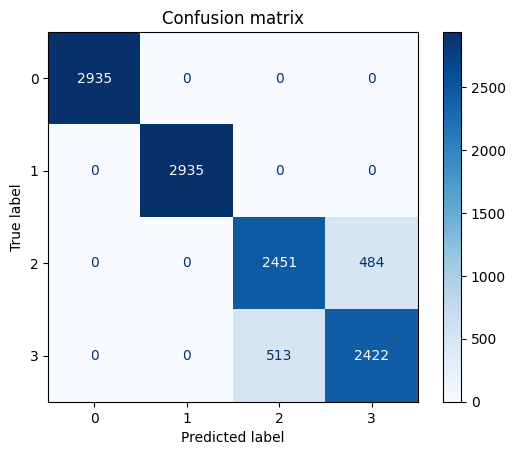

Found 11740 files belonging to 4 classes.
['rotated_0', 'rotated_180', 'rotated_90', 'rotated_minus_90']
Number of batches in dataset: 367
367/367 ━━━━━━━━━━━━━━━━━━━━ 355s 963ms/step
Total prediction time: 354.72 seconds
Predictions saved to c:\Users\User\DataScience\aug24_cds_int_analysis-of-covid-19-chest-x-rays\csv_files\image_orientation\test_on_unknown_resnet50_predicted_orientations.csv
                  precision    recall  f1-score   support

       rotated_0       0.06      0.00      0.01      2935
     rotated_180       0.28      0.73      0.41      2935
      rotated_90       0.05      0.05      0.05      2935
rotated_minus_90       0.37      0.11      0.17      2935

        accuracy                           0.22     11740
       macro avg       0.19      0.22      0.16     11740
    weighted avg       0.19      0.22      0.16     11740



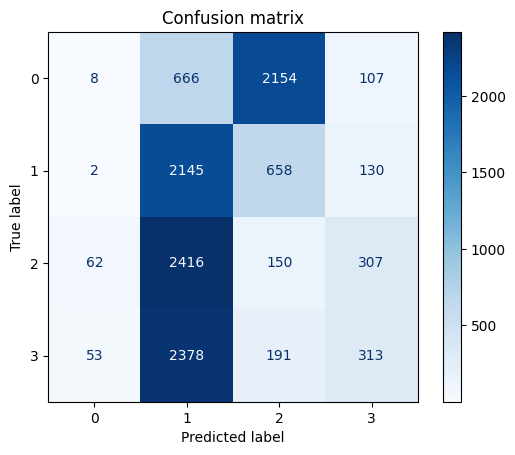

In [ ]:
# ----run tests and find rotated images in the original dataset-------

#---init utilizer objects

model_mobnet_path = os.path.join(PROJECT_DIR, "models", "orientation_classifier_224x224_aug_head1_mobnet.keras")
model_resnet50_path = os.path.join(PROJECT_DIR, "models", "orientation_classifier_224x224_aug_head1_resnet50.keras")
u_mobnet = ModelUtilizer(model_name="mobnet", model_type=mt.MOBILENET, input_shape=(224,224,3), alt_model_path=model_mobnet_path)
u_resnet = ModelUtilizer(model_name="resnet50", model_type=mt.RESNET50, input_shape=(224,224,3), alt_model_path=model_resnet50_path)

#--------------------------------------------------------------------------------------------
#----tests and predictions on augmented images from original and to model unknown datasets--- 
#--------------------------------------------------------------------------------------------

# >>> select dataset: "unknown" or "original"
original_or_unknown = "unknown" # "original"
# >>> select prediction mode: test(labeled data) or prediction(unlabeled data)
test_or_prediction = "test" # "prediction"

#loop through downscaled original/unknown dataset, pridict orientation by model, and save to csv
list_df_pred = []
pred_times = []
df = None
dataset_dir = None

all_predictions = None
dataset_type = None

if test_or_prediction == "test":
    dataset_type=dt.TEST
    if original_or_unknown == "original":
        dataset_dir = os.path.join(PROJECT_DIR, "data_224x224", "for_orientation_classification", "original", 
                                "labeled_test_augmented_from_original_224x224")
    elif original_or_unknown == "unknown":
        dataset_dir = os.path.join(PROJECT_DIR, "data_224x224", "for_orientation_classification", "unknown_to_the_model", "labeled_for_testing")
 
# original dataset only
elif test_or_prediction == "prediction":
    dataset_type=dt.PREDICT
    dataset_dir = os.path.join(PROJECT_DIR, "data_224x224", "orientation", "to_be_predicted")

# use both models for prediction and store results to csv
for m_utiliser in (u_mobnet, u_resnet):
    
    csv_path = os.path.join(PROJECT_DIR, "csv_files", "image_orientation", 
                            f"{test_or_prediction}_on_{original_or_unknown}_{m_utiliser.model_name}_predicted_orientations.csv")
    df_predicted, time_spent = m_utiliser.predict_on_dataset(   dataset_type=dataset_type, 
                                                                dataset_dir=dataset_dir,
                                                                class_to_label_map=class_to_orientation_map["long"], 
                                                                csv_output_path=csv_path)
    df_predicted.to_csv(csv_path, index=False) 
    list_df_pred.append(df_predicted)
    
    # for labeled data only
    if test_or_prediction == "test":
        m_utiliser.show_classification_report(df_predicted, normalize_cm=None)


all_predictions = pd.concat(list_df_pred, ignore_index=True)    #reset index
csv_path = os.path.join(PROJECT_DIR, "csv_files", "image_orientation", 
                            f"{test_or_prediction}_on_{original_or_unknown}_mobnet_resnet50_predicted_orientations.csv")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


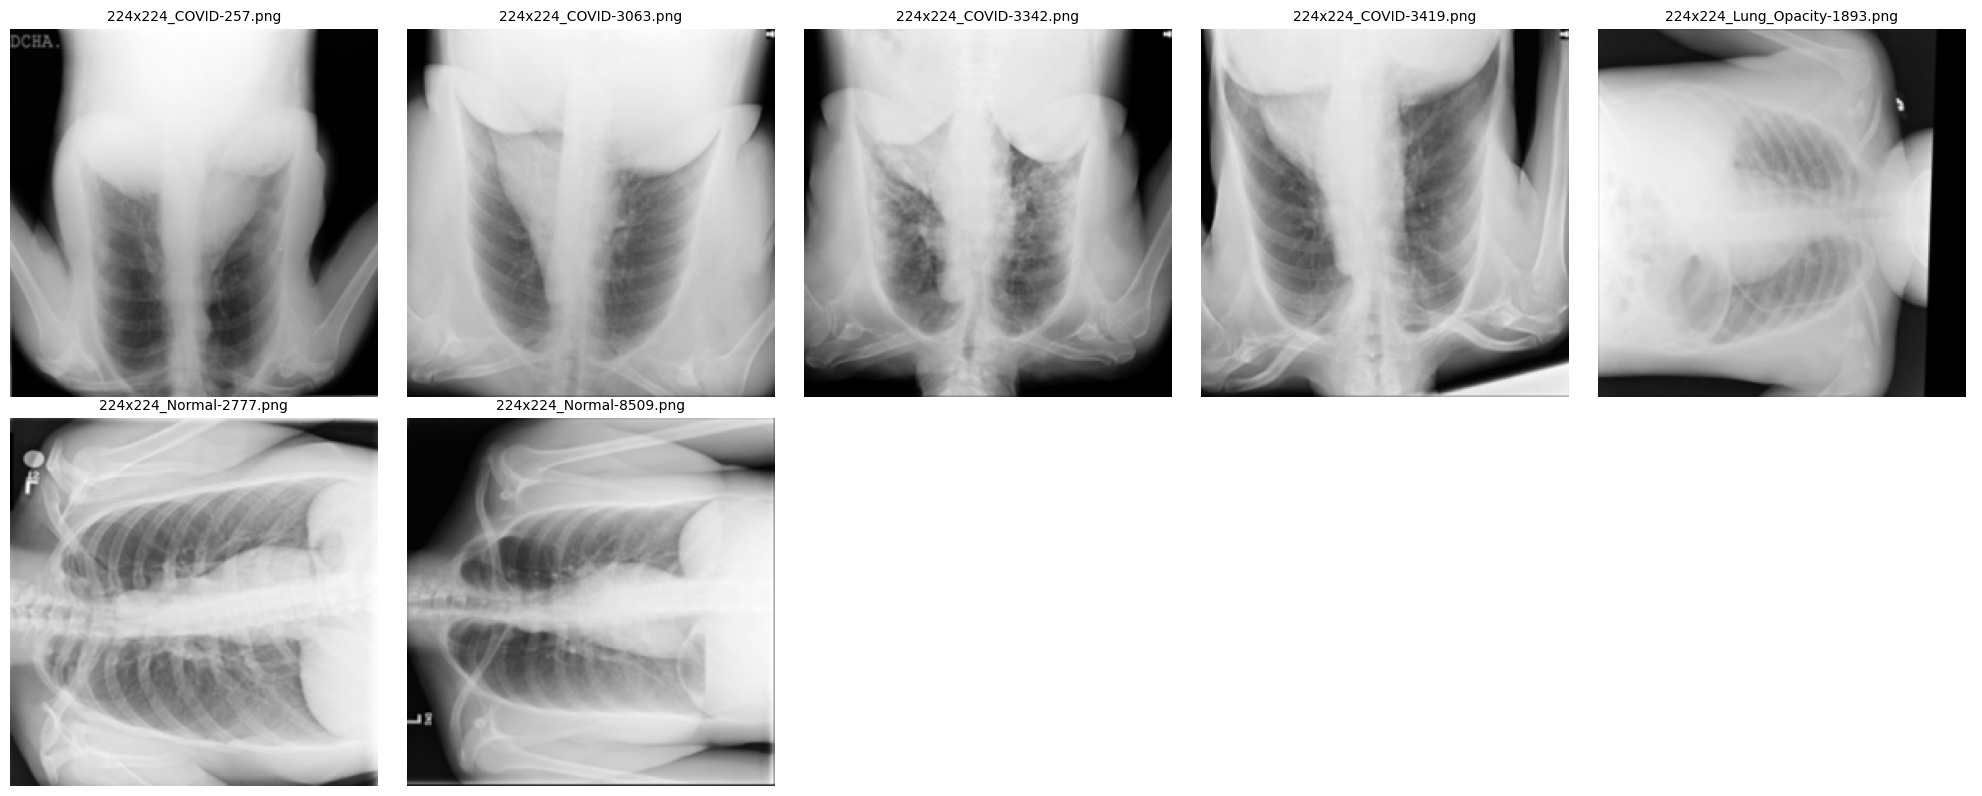

In [ ]:

#-----identifying truly rotated  images from original dataset--------------

# created a df where the class is one of the rotated across both predictions
mobnet_pred_path = os.path.join(PROJECT_DIR, "csv_files", "image_orientation", "prediction_mobnet_predicted_orientations.csv")
resnet_pred_path = os.path.join(PROJECT_DIR, "csv_files", "image_orientation", "prediction_resnet50_predicted_orientations.csv")
  
df_m = pd.read_csv(mobnet_pred_path, index_col=0)
df_r = pd.read_csv(resnet_pred_path, index_col=0)
#df_m.head()

# Merge on img_name
merged_df = df_m.merge(df_r, on="img_name", suffixes=("_1", "_2"))

# Keep rows where both predictions are not 'rotated_0'
df_both_preds_as_rotated = merged_df[
    (merged_df["predicted_label_1"] != "rotated_0") &
    (merged_df["predicted_label_2"] != "rotated_0")
]

df_both_preds_as_rotated = df_both_preds_as_rotated[["img_name", "predicted_label_1", "confidence_1", "predicted_label_2", "confidence_2", ]]

df_both_preds_as_rotated.shape ##14 images

img_names = df_both_preds_as_rotated["img_name"].tolist()
from_dir = os.path.join(PROJECT_DIR, "data_224x224", "for_orientation_classification", "original", "unlabeled_to_be_predicted_full_original_224x224")
imgs, names = ip.load_images(img_names, from_dir=from_dir)
#ip.plot_images(imgs, titles=names)

#identified as truly rotated
truly_rotated_index = [2,4,5,6,9,11,12]
truly_rotated_imgs, truly_rotated_names = [imgs[i] for i in truly_rotated_index], [names[i] for i in truly_rotated_index],
ip.plot_images(truly_rotated_imgs, truly_rotated_names)




#                                         -----------------MISSION COMPLETED-----------------------